<img src="https://i.ibb.co/TcVMz44/logo.jpg" alt="logo" border="0" width=200>

# Computational Astrophysics 2021
---
## Eduard Larrañaga

Observatorio Astronómico Nacional\
Facultad de Ciencias\
Universidad Nacional de Colombia

---

## 04. SDSS Data with AstroML

### About this notebook

In this worksheet, we use the `astroML` package to download and read data from the SDSS server.

---

## Data from the SDSS

The usual way to download data from the SDSS server is going to the SQL search webpage

http://skyserver.sdss.org/dr16/en/tools/search/sql.aspx

or to the CASJobs site

http://casjobs.sdss.org/CasJobs/

and make an SQL query. For example, the following orders,

` 
SELECT\
  round(p.ra,6) as ra, round(p.dec,6) as dec,\
  p.run,                              --- comments are preceded by ---\
  round(p.extinction_r,3) as rExtSFD, --- r band extinction from SFD\
  round(p.modelMag_u,3) as uRaw,      --- ISM-uncorrected model mags\
  round(p.modelMag_g,3) as gRaw,      --- rounding up model magnitudes\
  round(p.modelMag_r,3) as rRaw,\
  round(p.modelMag_i,3) as iRaw,\
  round(p.modelMag_z,3) as zRaw,\
  round(p.modelMagErr_u,3) as uErr,   --- errors are important!\
  round(p.modelMagErr_g,3) as gErr,\
  round(p.modelMagErr_r,3) as rErr,\
  round(p.modelMagErr_i,3) as iErr,\
  round(p.modelMagErr_z,3) as zErr,\
  round(p.psfMag_u,3) as psfRaw,      --- psf magnitudes\
  round(p.psfMag_g,3) as psfRaw,\
  round(p.psfMag_r,3) as psfRaw,\
  round(p.psfMag_i,3) as psfRaw,\
  round(p.psfMag_z,3) as psfRaw,\
  round(p.psfMagErr_u,3) as psfuErr,\
  round(p.psfMagErr_g,3) as psfgErr,\
  round(p.psfMagErr_r,3) as psfrErr,\
  round(p.psfMagErr_i,3) as psfiErr,\
  round(p.psfMagErr_z,3) as psfzErr,\
  p.type,                   --- tells if a source is resolved or not\
  (case when (p.flags & '16') = 0 then 1 else 0 end) as ISOLATED\
INTO mydb.SDSSimagingSample\
FROM PhotoTag p\
WHERE\
    --- 10x2 sq.deg.\
  p.ra > 0.0 and p.ra < 10.0 and p.dec > -1 and p.dec < 1\
    --- resolved and unresolved sources\
  and (p.type = 3 OR p.type = 6) and\
    --- '4295229440' is magic code for no\
    --- DEBLENDED_AS_MOVING or SATURATED objects\
  (p.flags & '4295229440') = 0 and\
    --- PRIMARY objects only, which implies\
    --- !BRIGHT && (!BLENDED || NODEBLEND || nchild == 0)]\
  p.mode = 1 and\
    --- adopted faint limit (same as about SDSS limit)\
  p.modelMag_r < 22.5\
--- the end of query
`

selects a catalog with 330,000 sources in the region bounded by the coordinates $0^{\circ} < \alpha <10^{\circ}$ and $-1^{\circ} < \delta < 1^{\circ}$. 

This dataset includes objects of the type 3 (mostly galaxies) and type 6 (mostly stars and quasars) according to the classification of the SDSS database.


However, the `astroML.datasets` package incorporate a function, called to `fetch_imaging_sample` which  directly loads this same dataset from the SDSS Database server. DEtailed information about this function can be found at

https://www.astroml.org/modules/generated/astroML.datasets.fetch_imaging_sample.html

---

### Download the dataset

Using the `fetch_imaging_sample` function, we will download the dataset,

In [ ]:
!pip install astroML

     |████████████████████████████████| 112kB 6.9MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128665 sha256=85c0d53b91d4751aa17271ddecca7f7baef1c915d77f4ff9174c29b99dc179c8
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from astroML.datasets import fetch_imaging_sample

data = fetch_imaging_sample()

**Important Note: The first time that you call this command, the code will send a http request and download the data from the web and this may be time consuming! On subsequent calls, the data will be loaded from the local disk.**

### Analyzing the Dataset

The shape of the dataset has more than 330,000 samples.

In [ ]:
data.shape

(330753,)

The names of the stored attributes of these objects can be accesed via the `dtype` attribute,

In [ ]:
data.dtype.names

('ra',
 'dec',
 'run',
 'rExtSFD',
 'uRaw',
 'gRaw',
 'rRaw',
 'iRaw',
 'zRaw',
 'uErr',
 'gErr',
 'rErr',
 'iErr',
 'zErr',
 'uRawPSF',
 'gRawPSF',
 'rRawPSF',
 'iRawPSF',
 'zRawPSF',
 'upsfErr',
 'gpsfErr',
 'rpsfErr',
 'ipsfErr',
 'zpsfErr',
 'type',
 'ISOLATED')

The 10 first features names in the data set are

In [ ]:
data.dtype.names[:10]

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr')

These features include

'ra': right ascension\
'dec': declination\
'rExtSFD': r band extinsion from SFD\
'uRaw': raw photometric data in the u band\
'gRaw': raw photometric data in the g band\
'rRaw': raw photometric data in the r band\
'iRaw': raw photometric data in the i band\
'zRaw': raw photometric data in the z band\
'uErr': error data in the u band\
...

etc.

This dataset includes objects of the `'type' = 3` (mostly galaxies) and `'type' = 6` (mostly stars and quasars) according to the classification of the SDSS database.

The filters in the SDSS database have the following behavior
<center>
<img src="https://www.astroml.org/_images/plot_sdss_filters_1.png" width=600>
</center>

Data from each feature can be easily accesed. For example, the right ascension of the first 10 samples are

In [ ]:
data['ra'][:10]

array([[0.358174],
       [0.358382],
       [0.357898],
       [0.35791 ],
       [0.358881],
       [0.162688],
       [0.142353],
       [0.142009],
       [0.121992],
       [0.221928]])

In [ ]:
data['ra'][:10], data['dec'][:10]

(array([[0.358174],
        [0.358382],
        [0.357898],
        [0.35791 ],
        [0.358881],
        [0.162688],
        [0.142353],
        [0.142009],
        [0.121992],
        [0.221928]]), array([[-0.508718],
        [-0.551157],
        [-0.570892],
        [-0.426526],
        [-0.505625],
        [-0.590807],
        [-0.613267],
        [-0.585848],
        [-0.462113],
        [-0.515993]]))

We can extract some of the data from the loaded dataset. For example, lets extractthe first 5000 objects of the type 6 (stars and quasars),

In [ ]:
# Define the filter according to the type of the data (type 6 represents stars)
objtype = data['type']==6
startype= objtype.flatten() # We flatten the selection to use it as a filter

In [ ]:
# Choose 5000 objects of this type
stars = data[startype][:5000]

In [ ]:
stars.shape

(5000,)

In [ ]:
stars['dec'][:10]

array([[-0.551157],
       [-0.426526],
       [-0.515993],
       [-0.515987],
       [-0.428948],
       [-0.515826],
       [-0.595052],
       [-0.548123],
       [-0.580568],
       [-0.541932]])

### Visualiazing the data

We can easily create diagrams using the dataset. For example, for the `stars` subset that we created, we can plot the declination vs g-band magnitude, 

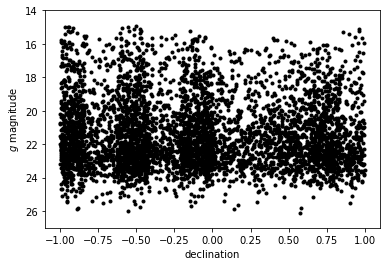

In [ ]:
plt.figure()
plt.plot(stars['dec'],stars['gRaw'], '.k')
plt.xlabel(r'declination')
plt.ylabel(r'$g$ magnitude')
plt.ylim(27, 14) #note the inversion in the magnitude axis for a better visualization
plt.show()